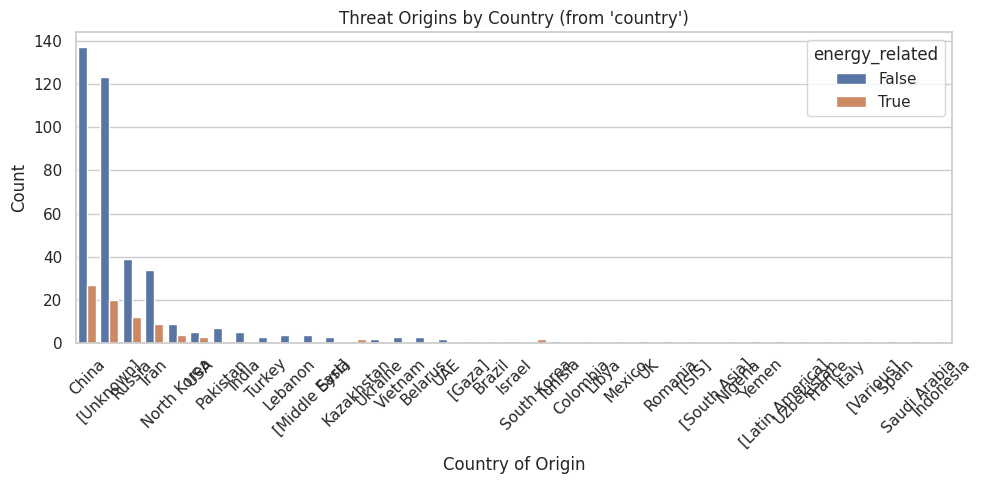

/scratch/slurm_tmpdir/job_1498628/ipykernel_860457/1362387838.py:101: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


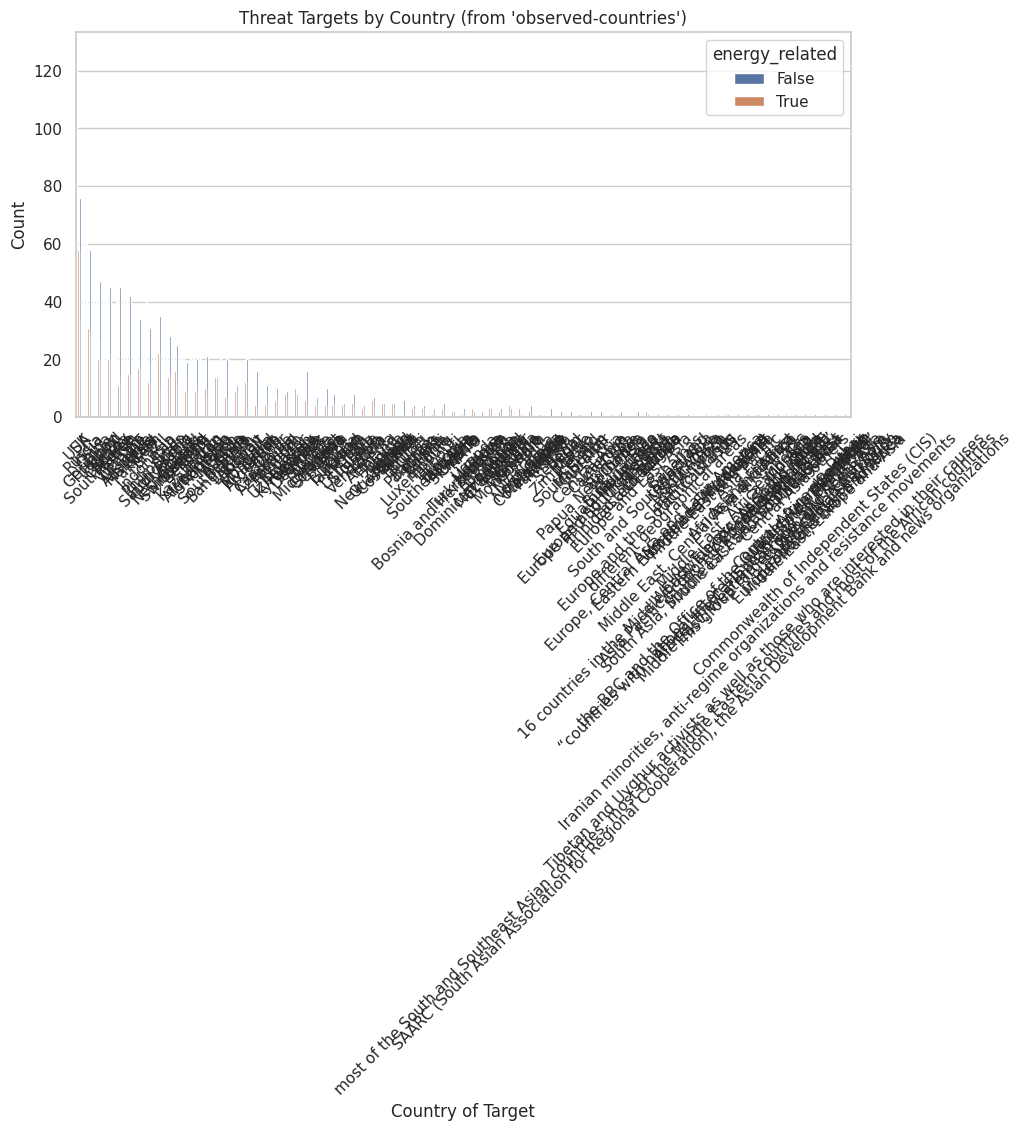

/scratch/slurm_tmpdir/job_1498628/ipykernel_860457/1362387838.py:111: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_origin = origin_counts.groupby("energy_related", group_keys=False).apply(


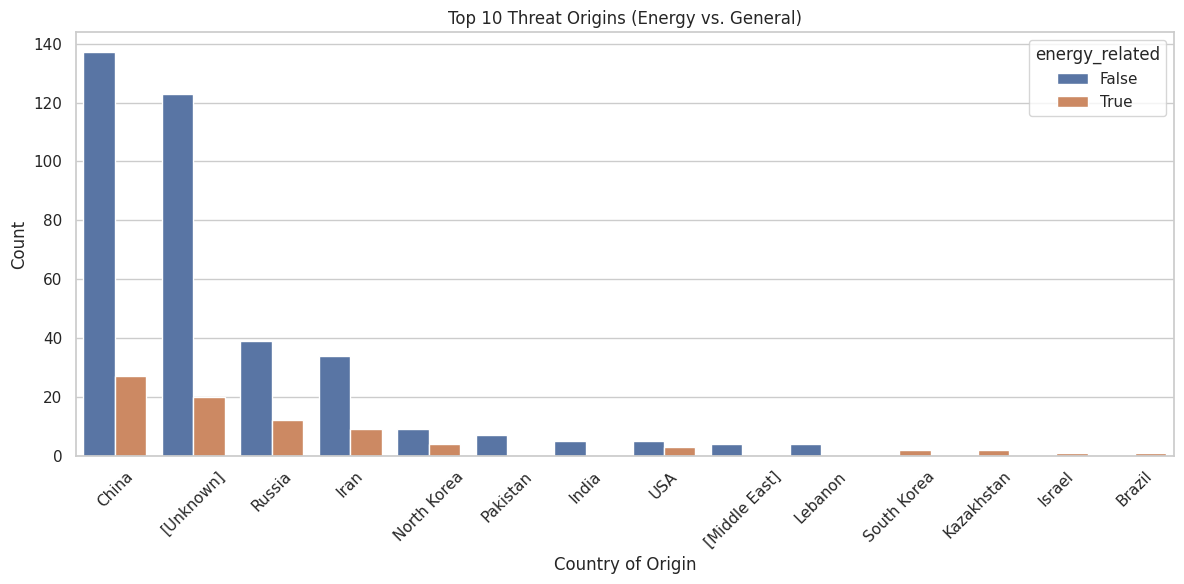

/scratch/slurm_tmpdir/job_1498628/ipykernel_860457/1362387838.py:132: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_target = target_counts.groupby("energy_related", group_keys=False).apply(


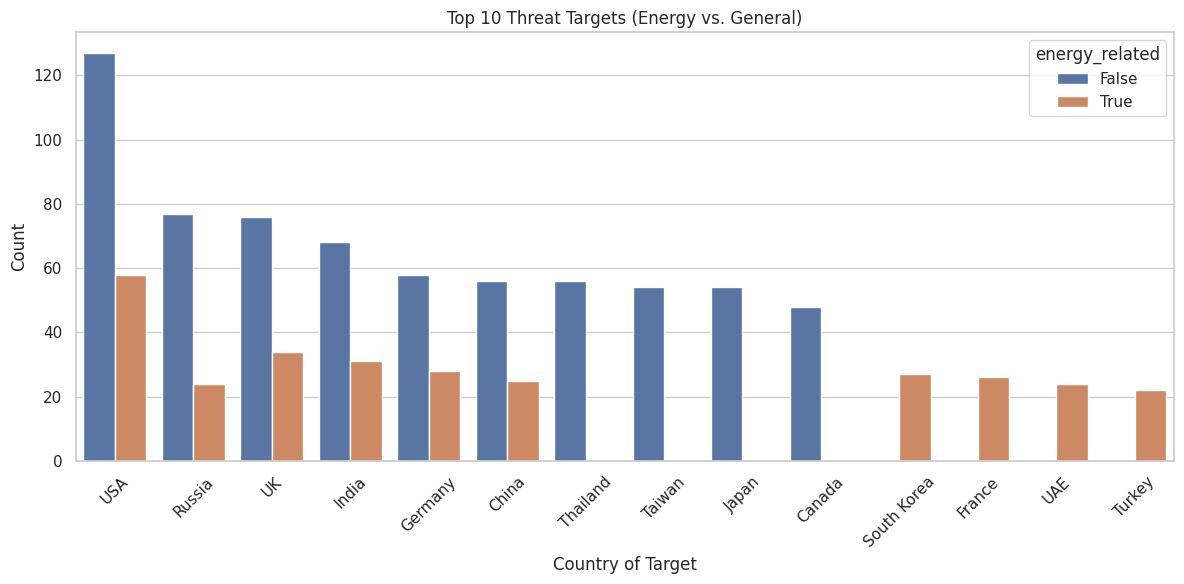

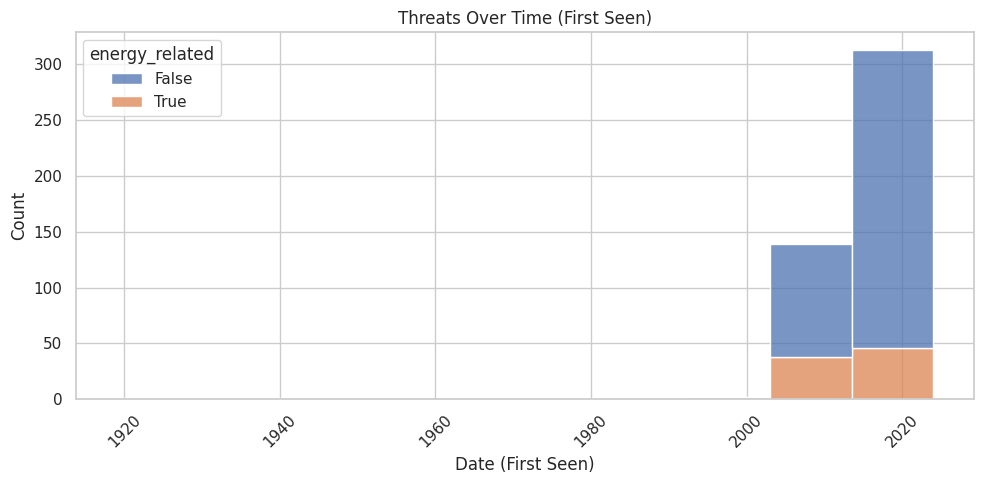

In [2]:
#this datasets has a lot of overlap with malpedia, so it is not investigated further.
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a seaborn style (optional)
sns.set_theme(style="whitegrid")

# =============================================================================
# Data Loading & Reformatting
# =============================================================================

# Filepath to your JSON file (adjust as needed)
json_filepath = "datasets/ThaiCERT.json"  # Replace with your actual filename

# Load the JSON file
with open(json_filepath, 'r') as f:
    data = json.load(f)

# The threat data is assumed to be in the "values" key
threat_values = data.get("values", [])

# Helper function to determine energy-related flag from "observed-sectors"
def determine_energy_related(item):
    observed_sectors = item.get("observed-sectors")
    if observed_sectors and isinstance(observed_sectors, list):
        # Return True if any sector contains "energy" (case-insensitive)
        return any("energy" in sector.lower() for sector in observed_sectors if isinstance(sector, str))
    return False

# Reformat each threat item into a common structure
formatted_data = []
for item in threat_values:
    formatted_item = {
        # Use "first-seen" as the date (it might be just a year string)
        "date": item.get("first-seen", ""),
        # Use the provided description text
        "description": item.get("description", ""),
        # Country of origin comes from the "country" attribute (a list)
        "country_of_origin": item.get("country", []),
        # Target country comes from "observed-countries" (a list)
        "country_of_target": item.get("observed-countries", []),
        # energy_related is determined from "observed-sectors"
        "energy_related": determine_energy_related(item)
    }
    formatted_data.append(formatted_item)

# Convert the formatted data to a DataFrame
df = pd.DataFrame(formatted_data)

# =============================================================================
# Preparing Data for Analysis
# =============================================================================
# For analysis, we want to work with individual country entries.
# We'll create exploded DataFrames for origin and target countries.

# Process country_of_origin (ensure it's a list and then explode)
df_origin = df.copy()
df_origin["country_of_origin"] = df_origin["country_of_origin"].apply(lambda x: x if isinstance(x, list) else [])
df_origin = df_origin.explode("country_of_origin")
df_origin = df_origin.dropna(subset=["country_of_origin"])

# Process country_of_target similarly
df_target = df.copy()
df_target["country_of_target"] = df_target["country_of_target"].apply(lambda x: x if isinstance(x, list) else [])
df_target = df_target.explode("country_of_target")
df_target = df_target.dropna(subset=["country_of_target"])

# =============================================================================
# Analysis Functions
# =============================================================================

def analyze_geopolitical_alignments(df_origin):
    """
    Plot a count of threat origins by country (using the "country_of_origin" field).
    Colors indicate whether the threat is energy-related.
    """
    plt.figure(figsize=(10, 5))
    order = df_origin["country_of_origin"].value_counts().index
    sns.countplot(data=df_origin, x="country_of_origin", hue="energy_related", order=order)
    plt.title("Threat Origins by Country (from 'country')")
    plt.xlabel("Country of Origin")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_threat_targets(df_target):
    """
    Plot a count of threat targets by country (using the "country_of_target" field).
    Colors indicate whether the threat is energy-related.
    """
    plt.figure(figsize=(10, 5))
    order = df_target["country_of_target"].value_counts().index
    sns.countplot(data=df_target, x="country_of_target", hue="energy_related", order=order)
    plt.title("Threat Targets by Country (from 'observed-countries')")
    plt.xlabel("Country of Target")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_threat_origins_vs_targets(df_origin, df_target):
    """
    Compare the top countries in threat origins and targets.
    This function creates bar plots for both.
    """
    # Origins
    origin_counts = df_origin.groupby(["country_of_origin", "energy_related"]).size().reset_index(name="count")
    top_origin = origin_counts.groupby("energy_related", group_keys=False).apply(
        lambda grp: grp.sort_values("count", ascending=False).head(10)
    )
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_origin,
        x="country_of_origin",
        y="count",
        hue="energy_related",
        order=top_origin.sort_values("count", ascending=False)["country_of_origin"]
    )
    plt.title("Top 10 Threat Origins (Energy vs. General)")
    plt.xlabel("Country of Origin")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Targets
    target_counts = df_target.groupby(["country_of_target", "energy_related"]).size().reset_index(name="count")
    top_target = target_counts.groupby("energy_related", group_keys=False).apply(
        lambda grp: grp.sort_values("count", ascending=False).head(10)
    )
    
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_target,
        x="country_of_target",
        y="count",
        hue="energy_related",
        order=top_target.sort_values("count", ascending=False)["country_of_target"]
    )
    plt.title("Top 10 Threat Targets (Energy vs. General)")
    plt.xlabel("Country of Target")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_time_series_by_year(df):
    """
    Group the threats by year (from the 'first-seen' field) and plot a bar chart.
    This function assumes that the 'date' field contains just a year (e.g. "2016").
    """
    df_time = df.copy()
    # Convert the date string to a year (as integer); errors become NaT and are dropped.
    df_time["year"] = pd.to_datetime(df_time["date"], errors="coerce", format="%Y").dt.year
    df_time = df_time.dropna(subset=["year"])
    df_time["year"] = df_time["year"].astype(int)
    
    # Group by year and energy-related flag
    counts = df_time.groupby(["year", "energy_related"]).size().reset_index(name="count")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=counts, x="year", y="count", hue="energy_related")
    plt.title("Threats Over Time (by Year)")
    plt.xlabel("Year (First Seen)")
    plt.ylabel("Threat Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# =============================================================================
# Run Analyses
# =============================================================================

analyze_geopolitical_alignments(df_origin)
analyze_threat_targets(df_target)
analyze_threat_origins_vs_targets(df_origin, df_target)
analyze_time_series(df)
